### Import libraries and set options to style and rows/columns limit

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sns.set_style("ticks")
%matplotlib inline
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

### Import data to Train and Test

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [4]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Define model parameters structure 

In [5]:
model_parameters  = {
                    "x_numeric"       : [],
                    "x_non_numeric"   : [],
                    "y"     : ["SalePrice"]
                    }

### SalesPrice Distribution

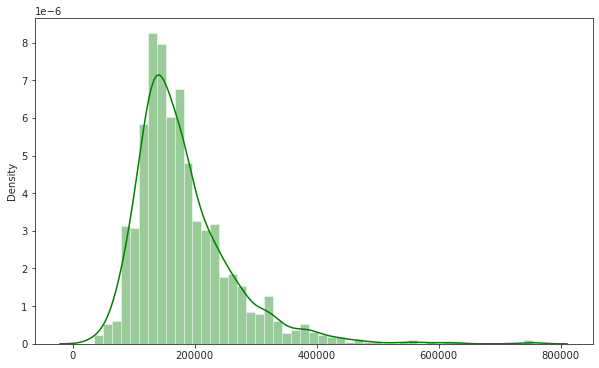

In [6]:
fig, ax = plt.subplots(figsize=(10,6));
sns.distplot(df_train[model_parameters["y"]], color="g", ax=ax);

### Functions to Data Wrangling and Feature Selection

In [7]:
# Remove values of parameters when unecessary to train model
def remove_parameter(model_parameters, parameter_class, parameter_value):
    try:
      model_parameters[parameter_class].remove(parameter_value)
    except:
        print(f"{parameter_value} not found in parameter class: {parameter_class}.")

In [8]:
# Calc percentage of null values
def isna_column_percentage(df, percentage):
    
    return ( round(df.isna().sum() / len(df),4) * 100 ) [(df.isna().sum() / len(df)).gt(percentage/100)]

In [9]:
# Fill null values for numeric and non numeric columns
def fill_na(df):
    fillna_values = {}
    for column in df[model_parameters["x_non_numeric"]]:
        fillna_values.update( {column : "Null"} )
        
    for column in df[model_parameters["x_numeric"]]:
        fillna_values.update( {column : 0} )
    
    return df.fillna(value=fillna_values)

In [10]:
# Calc VIF Variance Inflation Factors to remove strong multicollinearity
def vif(df):

    x = df.assign(const=1)

    df_vif = pd.DataFrame([variance_inflation_factor(x.values, i) 
                                    for i in range(x.shape[1])], 
                                    index=x.columns,
                                    columns=["VIF"])
    return df_vif

### Data Wrangling

In [11]:
# Split variables in numeric and non numeric. Insert into model parameters
model_parameters["x_numeric"] = list(df_train.select_dtypes(include=np.number).columns)
model_parameters["x_non_numeric"] = list(df_train.select_dtypes(exclude=np.number).columns)

In [12]:
# drop wrong columns
remove_parameter(model_parameters,"x_numeric","SalePrice")
remove_parameter(model_parameters,"x_numeric","Id")

#### Frequency of null values

In [13]:
isna_column_percentage(df=df_train,percentage=0).sort_values(ascending=False)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [14]:
# drop null frequency greater than 15%
drop_columns = list(isna_column_percentage(df=df_train,percentage=15).index)
[remove_parameter(model_parameters,"x_numeric",column) for column in drop_columns]
[remove_parameter(model_parameters,"x_non_numeric",column) for column in drop_columns]

Alley not found in parameter class: x_numeric.
FireplaceQu not found in parameter class: x_numeric.
PoolQC not found in parameter class: x_numeric.
Fence not found in parameter class: x_numeric.
MiscFeature not found in parameter class: x_numeric.
LotFrontage not found in parameter class: x_non_numeric.


[None, None, None, None, None, None]

In [15]:
# Fill null values
df_train = fill_na(df_train)
df_test = fill_na(df_test)

### Feature Selection

#### Numerical features

* All numeric features is continuous
* Analysis to remove features with weak correlation on SalePrice
* Exclude features with high correlations each other (excluded SalePrice)

In [16]:
# Analysis to remove weakly correlated features with SalePrice
corr = df_train[model_parameters["x_numeric"] + model_parameters["y"] ].corr()
# Convert values to absolute values
abs_corr = corr[model_parameters["x_numeric"] + model_parameters["y"] ].applymap(lambda x: abs(x))

In [17]:
# Remove weak correlation with SalePrice
weak_correlation = list(abs_corr[abs_corr["SalePrice"].lt(0.5)].index)
[remove_parameter(model_parameters,"x_numeric",column) for column in weak_correlation];

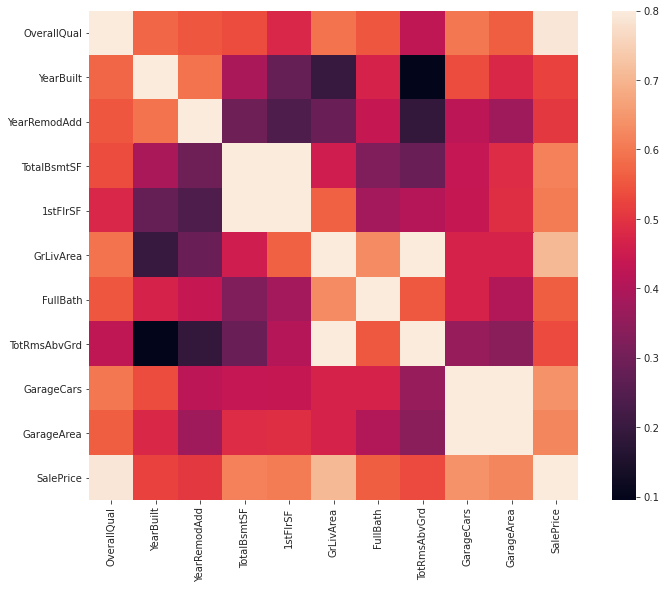

In [18]:
# Analyse of correlation between features
corr = df_train[model_parameters["x_numeric"] + model_parameters["y"] ].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

In [19]:
# Keep the most relevant features to SalesPrice without high correlation with each other
lower_significance = ["1stFlrSF","TotRmsAbvGrd","GarageArea","FullBath"]
[remove_parameter(model_parameters,"x_numeric",column) for column in lower_significance];

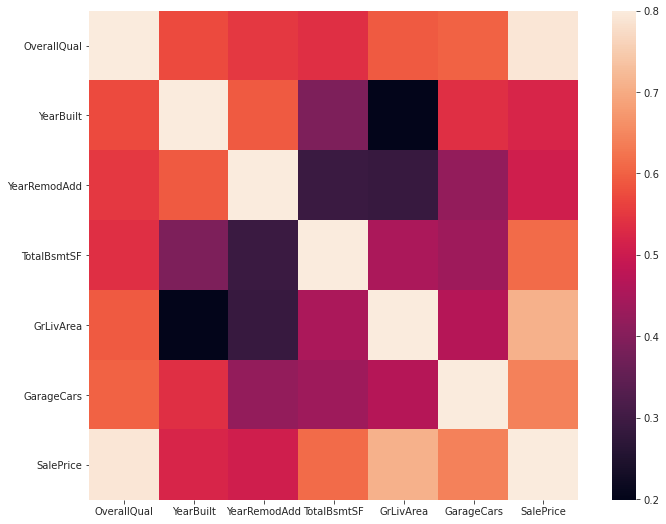

In [20]:
# Analyse of correlation between features
corr = df_train[model_parameters["x_numeric"] + model_parameters["y"] ].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

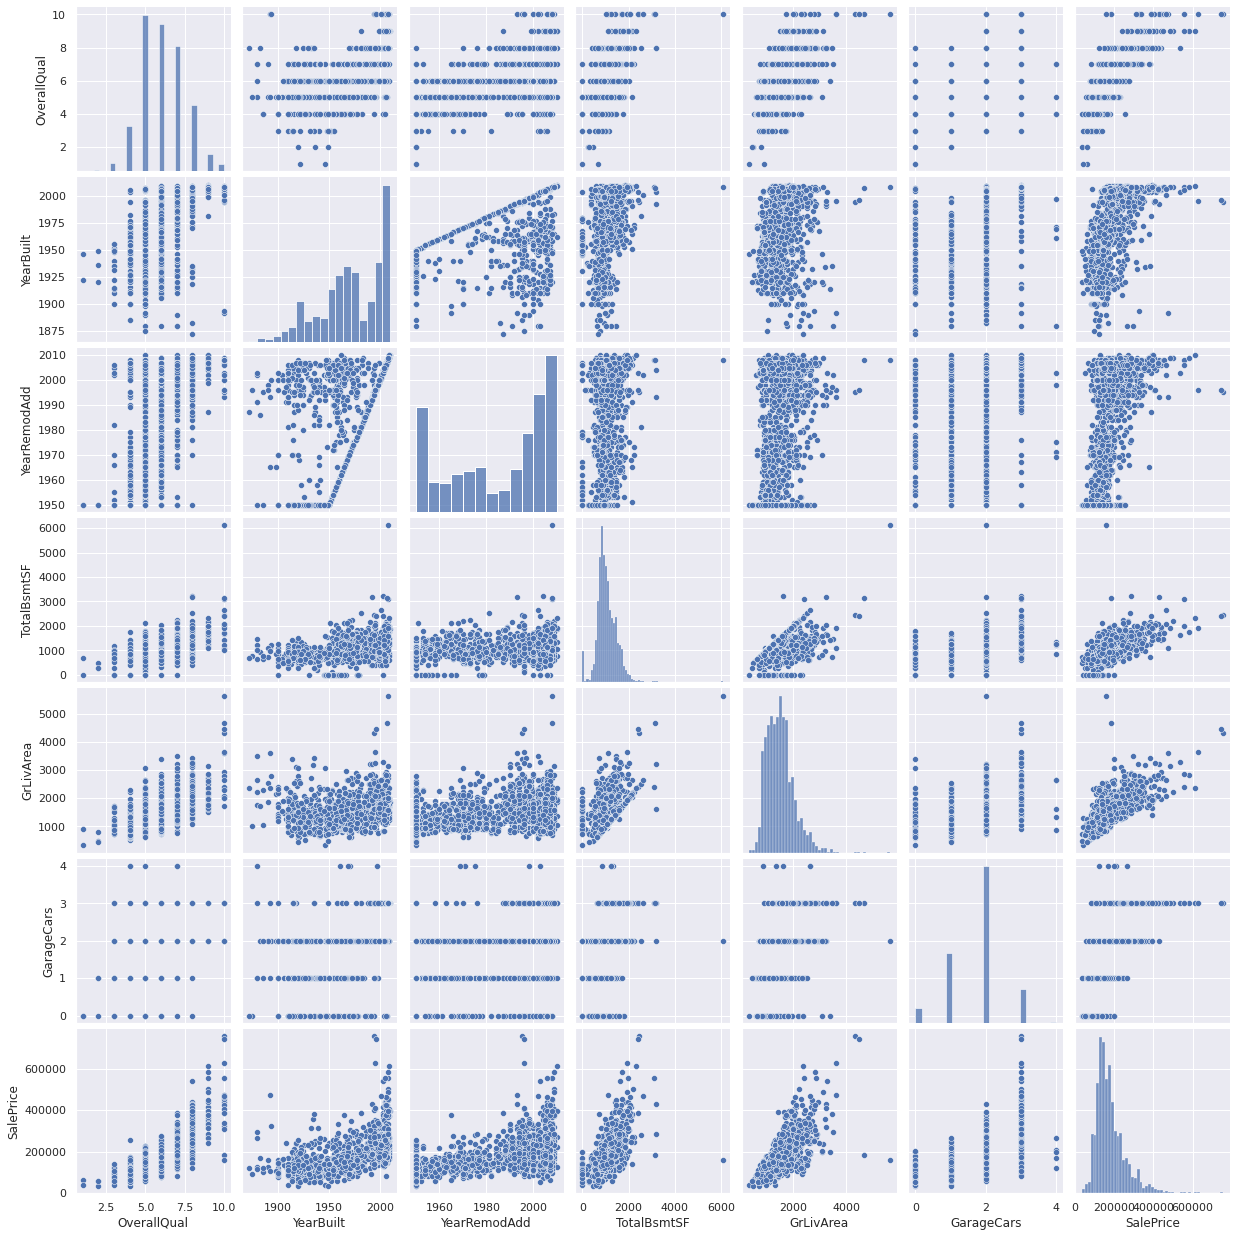

In [21]:
sns.set()
sns.pairplot(df_train[model_parameters["x_numeric"] + model_parameters["y"]], height = 2.5)
plt.show();

### Non numeric features

* Transform categories into dummies
* Exclude dummies that not exist in both datasets (train, test)

In [22]:
# Create dummies and drop first 
x_train_dummies = pd.get_dummies(data=df_train[model_parameters["x_non_numeric"]], drop_first=True)
x_test_dummies = pd.get_dummies(data=df_test[model_parameters["x_non_numeric"]], drop_first=True)

In [23]:
# List missing dummies
missing_dummy_train = [dummy for dummy in list(x_train_dummies.columns) if dummy not in list(x_test_dummies.columns)]
missing_dummy_test = [dummy for dummy in list(x_test_dummies.columns) if dummy not in list(x_train_dummies.columns)]

In [24]:
# Drop dummies that not exist in both datasets (train, test)
x_train_dummies = x_train_dummies.drop(columns=missing_dummy_train)
x_test_dummies = x_test_dummies.drop(columns=missing_dummy_test)

In [25]:
# Analysis to remove weakly correlated features with SalePrice
corr = pd.concat([x_train_dummies,df_train[model_parameters["y"]]],axis=1).corr()
# Convert values to absolute values
abs_corr = corr.applymap(lambda x: abs(x))

In [26]:
# Remove weak correlation with SalePrice
weak_correlation = list(abs_corr[abs_corr["SalePrice"].lt(0.3)].index)
x_train_dummies = x_train_dummies.drop(columns=weak_correlation)
x_test_dummies = x_test_dummies.drop(columns=weak_correlation)


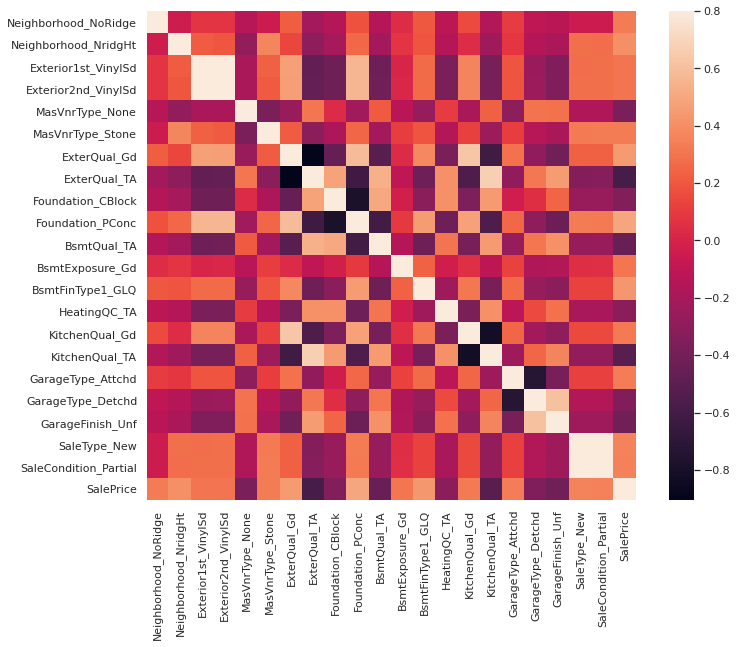

In [27]:
# Analyse of correlation between features
corr = pd.concat([x_train_dummies,df_train[model_parameters["y"]]],axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

In [28]:
# Keep the most relevant features to SalesPrice without high correlation with each other
lower_significance = ["Exterior2nd_VinylSd","SaleCondition_Partial","GarageFinish_Unf","GarageType_Detchd","KitchenQual_TA","Foundation_CBlock","ExterQual_TA","BsmtQual_TA","Foundation_PConc","ExterQual_Gd","MasVnrType_Stone","Exterior1st_VinylSd","MasVnrType_None","GarageType_Attchd"]
x_train_dummies = x_train_dummies.drop(columns=lower_significance)
x_test_dummies = x_test_dummies.drop(columns=lower_significance)

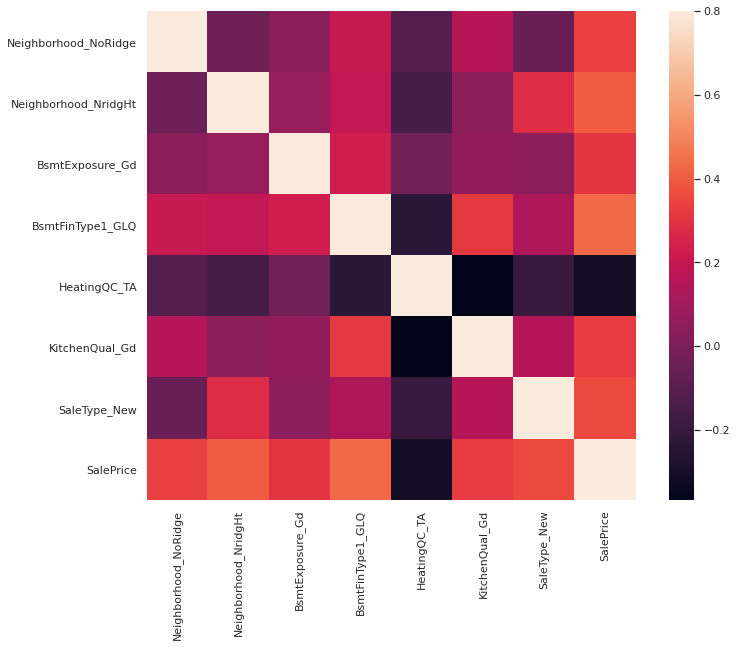

In [29]:
# Analyse of correlation between features
corr = pd.concat([x_train_dummies,df_train[model_parameters["y"]]],axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

### Multicollinearity

In [30]:
df_vif_numeric = vif(df_train[model_parameters["x_numeric"]])

In [31]:
df_vif_numeric.sort_values(ascending=False,by="VIF")

,VIF
const,14915.255800
OverallQual,2.704116
YearBuilt,2.114612
GarageCars,1.844324
GrLivArea,1.805732
YearRemodAdd,1.728871
TotalBsmtSF,1.528248


In [32]:
df_vif_all = vif(pd.concat([df_train[model_parameters["x_numeric"]],x_train_dummies],axis=1))

In [33]:
df_vif_all.sort_values(ascending=False,by="VIF").head(25)

,VIF
const,20821.707289
OverallQual,2.903888
YearBuilt,2.291187
YearRemodAdd,2.089845
GrLivArea,1.924938
GarageCars,1.866821
TotalBsmtSF,1.654715
KitchenQual_Gd,1.578312
BsmtFinType1_GLQ,1.476963
HeatingQC_TA,1.289412


In [34]:
hight_vif = list(df_vif_all.sort_values(ascending=False,by="VIF").head(25).index)

### Train Model (only numerical features)

In [35]:
# subset dataframe to use on model fit
df_train_x = df_train[model_parameters["x_numeric"]]
df_train_x = df_train_x.assign(const=1)
df_train_y = df_train[model_parameters["y"]]

In [36]:
lin_reg_numeric = sm.OLS(df_train_y, df_train_x).fit()

In [37]:
lin_reg_numeric.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     815.0
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:20   Log-Likelihood:                -17468.
No. Observations:                1460   AIC:                         3.495e+04
Df Residuals:                    1453   BIC:                         3.499e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual   1.912e+04   1186.027     16.123      0.000    1.68e+04    2.14e+04
YearBuilt      221.1405     48.025      4.605      0.000     126.934     315.347
YearRemodAdd   275.7394     63.527      4.340      0.000     151.124     400.355
TotalBsmtSF     30.8610      2.811     10.979      0.000      25.347      36.375
GrLivArea       50.3610      2.551     19.743      0.000      45.357      55.365
GarageCars    1.439e+04   1812.667      7.939      0.000    1.08e+04    1.79e+04
const        -1.053e+06   1.22e+05     -8.650      0.000   -1.29e+06   -8.14e+05
==============================================================================
Omnibus:                      440.903   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48686.121
Skew:                          -0.258   Prob(JB):                         0.00
Kurtosis:                      31.285   Cond. No.                     4.12e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
lin_reg_numeric.params

OverallQual     1.912175e+04
YearBuilt       2.211405e+02
YearRemodAdd    2.757394e+02
TotalBsmtSF     3.086096e+01
GrLivArea       5.036104e+01
GarageCars      1.439158e+04
const          -1.053327e+06
dtype: float64

### Train Model (numerical and non numerical features)

In [39]:
# subset dataframe to use on model fit
df_train_x = pd.concat([df_train[model_parameters["x_numeric"]],x_train_dummies],axis=1)
df_train_x = df_train_x.assign(const=1)
df_train_y = df_train[model_parameters["y"]]

In [40]:
lin_reg_all = sm.OLS(df_train_y, df_train_x).fit()

In [41]:
lin_reg_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     472.6
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:21   Log-Likelihood:                -17334.
No. Observations:                1460   AIC:                         3.470e+04
Df Residuals:                    1446   BIC:                         3.477e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
OverallQual           1.609e+04   1123.539     14.317      0.000    1.39e+04    1.83e+04
YearBuilt              141.4467     45.698      3.095      0.002      51.804     231.089
YearRemodAdd           259.3570     63.849      4.062      0.000     134.111     384.603
TotalBsmtSF             20.0402      2.674      7.495      0.000      14.796      25.285
GrLivArea               48.3970      2.408     20.102      0.000      43.674      53.120
GarageCars            1.274e+04   1667.121      7.643      0.000    9471.890     1.6e+04
Neighborhood_NoRidge  5.021e+04   6024.064      8.335      0.000    3.84e+04     6.2e+04
Neighborhood_NridgHt  3.797e+04   4595.590      8.262      0.000     2.9e+04     4.7e+04
BsmtExposure_Gd       3.003e+04   3355.751      8.950      0.000    2.35e+04    3.66e+04
BsmtFinType1_GLQ      1.012e+04   2450.678      4.131      0.000    5315.734    1.49e+04
HeatingQC_TA         -5011.7808   2273.827     -2.204      0.028   -9472.134    -551.427
KitchenQual_Gd       -8360.7694   2336.229     -3.579      0.000   -1.29e+04   -3778.009
SaleType_New          2.064e+04   3710.070      5.564      0.000    1.34e+04    2.79e+04
const                -8.338e+05   1.32e+05     -6.339      0.000   -1.09e+06   -5.76e+05
==============================================================================
Omnibus:                      610.888   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62152.773
Skew:                          -0.973   Prob(JB):                         0.00
Kurtosis:                      34.905   Cond. No.                     4.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
lin_reg_all.params

OverallQual              16085.774347
YearBuilt                  141.446728
YearRemodAdd               259.357044
TotalBsmtSF                 20.040202
GrLivArea                   48.397033
GarageCars               12742.123522
Neighborhood_NoRidge     50212.664416
Neighborhood_NridgHt     37967.223544
BsmtExposure_Gd          30033.462736
BsmtFinType1_GLQ         10122.998627
HeatingQC_TA             -5011.780771
KitchenQual_Gd           -8360.769369
SaleType_New             20641.110552
const                  -833828.278399
dtype: float64

### Predicting Test

In [43]:
# subset dataframe to use on model predict
df_test_x_numeric = df_test[model_parameters["x_numeric"]]
df_test_x_all = pd.concat([df_test[model_parameters["x_numeric"]],x_test_dummies],axis=1)
df_test_x_numeric = df_test_x_numeric.assign(const=1)
df_test_x_all = df_test_x_all.assign(const=1)

In [44]:
# Predict y
df_test_y_numeric = lin_reg_numeric.predict(df_test_x_numeric)
df_test_y_all = lin_reg_all.predict(df_test_x_all)

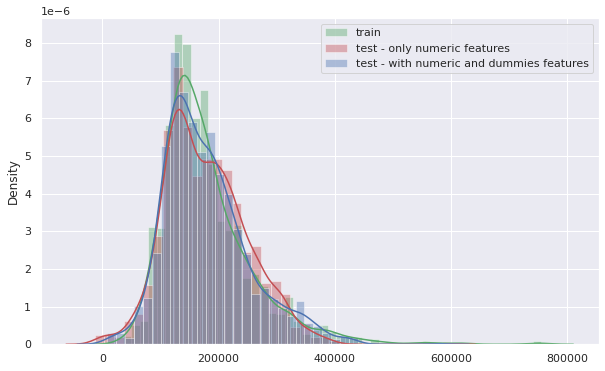

In [45]:
# Compare Train and Predicted Test
fig, ax = plt.subplots(figsize=(10,6));
sns.distplot(df_train_y, color="g", ax=ax, label="train");
sns.distplot(df_test_y_numeric, color="r", ax=ax, label="test - only numeric features");
sns.distplot(df_test_y_all, color="b", ax=ax, label="test - with numeric and dummies features");
leg = ax.legend();

### Export submission 

In [46]:
df_submission = pd.concat([df_test["Id"],df_test_y_all.rename('SalePrice')],axis=1)

In [47]:
df_submission.to_csv("data/my_submission.csv", index=False)